# Abstract: Amazone Fine Foods Customer Reviews Summarizer
Text summarization is the technique for generating a concise and precise summary of voluminous texts while focusing on the sections that convey useful information, and without losing the overall meaning.
Automatic text summarization aims to transform lengthy documents into shortened versions, something which could be difficult and costly to undertake if done manually.

Customer reviews can often be long and descriptive. Analyzing these reviews manually, as you can imagine, is really time-consuming. This is where the brilliance of Natural Language Processing can be applied to generate a summary for long reviews.

We will be working on `Amazon Fine Food Reviews` dataset. Our objective here is to generate a summary for the Food reviews using the `abstraction-based approach`.
### There are broadly two different approaches that are used for text summarization.
### 1. Extractive Summarization
In extraction-based summarization, a subset of words that represent the most important points is pulled from a piece of text and combined to make a summary. Think of it as a highlighter—which selects the main information from a source text.

### 2. Abstractive Summarization:
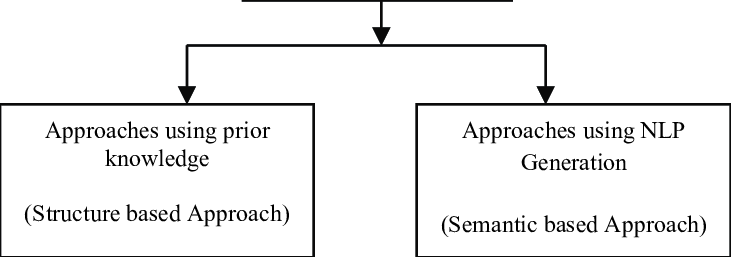
#### Example:
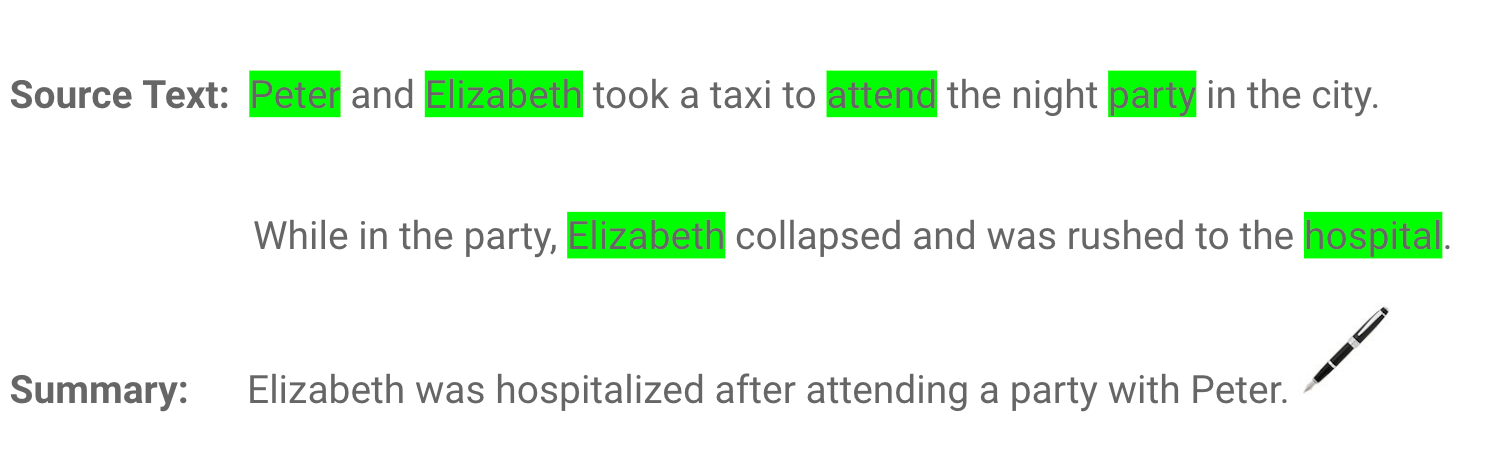
- New sentences is generated from the original text.
- This is in contrast to the extractive approach where we used only the sentences that were present. 
- The sentences generated through abstractive summarization might not be present in the original text

# Import the Libraries

In [1]:
import numpy as np
import pandas as pd 
import re
import math

import nltk
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
#  Download or update the stopword dictionary  
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nadkar.k/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Importing Dataset:
dataset is taken from Kaggle: https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

### Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

In [3]:
data=pd.read_csv("Dataset/Reviews.csv",nrows=100000)
# data=pd.read_csv("Dataset/Reviews.csv",nrows=50000)

### Displaying sample of Text and Summary we will be working on:

In [4]:
data[['Text', 'Summary']][:5]

,Text,Summary
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,Good Quality Dog Food
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",Not as Advertised
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...","""Delight"" says it all"
3,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,Cough Medicine
4,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",Great taffy


# Data Cleaning:
### Drop Duplicates and NA values

In [5]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


### Expanding the contractions

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

## Cleaning Steps:
    1. convert everything to lowercase    
    2. Removing html tags from datatset using beutifulsoup library 
    3. Contraction Mapping to change abbrevated statments to understandable english
    4. Remove `'s` and text within parenthesis
    5. Eliminate punctuations and special characters
    6. Remove stopwords
    7. Remove token words which are 1 charecter long 
    
### 1. Cleaning Text:

In [8]:
# Importing stopwords to remove from our data
stop_words = set(stopwords.words('english')) 
# Here we are using regular expression library to clean data
def text_cleaner(text,num):
    # Step 1    
    newString = text.lower()
    # Step 2
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    # Step 3
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    # step 4
    newString = re.sub(r"'s\b","",newString)
    # step 5
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    # step 6
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    # step 7
    long_words=[]
    for i in tokens:
        if len(i)>1:
            long_words.append(i)   
    return (" ".join(long_words)).strip()

- The BeautifulSoup library is used for parsing the data.
- BeautifulSoup converts the incoming text to Unicode characters and the outgoing text to UTF-8 characters, saving you the hassle of managing different charset encodings while scraping text from the web.
- To ensure the textual data is as noise-free as possible, we have performed some basic text cleaning.
- To assist us to do the processing, we have used a list of stopwords from the nltk library.

In [9]:
# cleaning text data:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

In [10]:
data['cleaned_text'] = cleaned_text

### 2. Cleaning Summary:

In [11]:
# Cleaning Summary data:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [12]:
data['cleaned_summary'] = cleaned_summary

#### Droping empty rows

In [13]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

### Data After Cleaning:

In [14]:
data[['cleaned_text', 'cleaned_summary']][:5]

,cleaned_text,cleaned_summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says it all
3,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
4,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy


# Data Preprocessing:

### Understanding the distribution of the sequences:
Get an overall idea about the distribution of length of the Text and Summary. This will help us fix the maximum length of the sequence

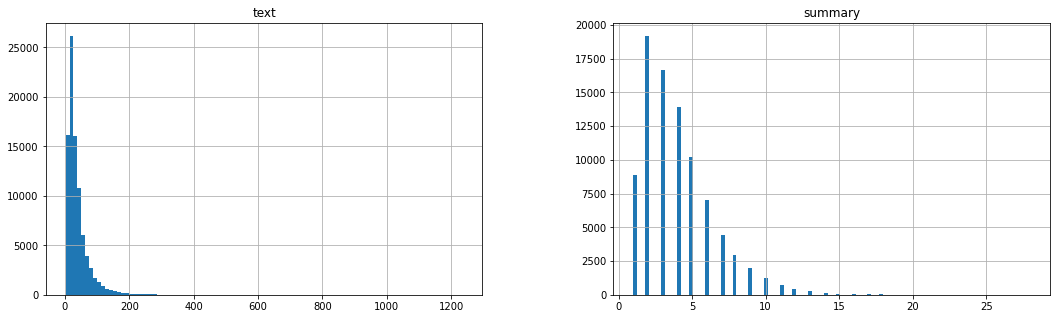

In [15]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 100, figsize=(18,5))
plt.show()

In [16]:
length_df.describe()

,text,summary
count,88351.000000,88351.000000
mean,38.792962,4.010549
std,36.660462,2.476991
min,2.000000,1.000000
25%,17.000000,2.000000
50%,28.000000,3.000000
75%,47.000000,5.000000
max,1235.000000,28.000000


#### Lets check how much summary data below 8

In [17]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print("Percentage of data summary length below 8: ", round(cnt/len(data['cleaned_summary']),2) * 100, "%")

Percentage of data summary length below 8:  94.0 %


#### Text data analysis:
- On average `text` length is between 2 to 200
- There is graduale decrease is number of phrases above 100
- We will consider 47 as threshold value for `text` length to avoid clipping to much data

#### Summary data analysis:
- On average `summary` length lies between 3 to 15
- the most of data lie between 3 to 10
- We will consider 8 as threshold value for `summury` length since 86% of data lies within length of 8

In [18]:
max_text_len=45
max_summary_len=8

#### Removing the reviews and summaries whose length falls below or equal to _max_text_len_ and _max_summary_len_

In [19]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

### Adding _START_ and _END_ tag to Summary:
Adding `sostok` as Start tag and `eostok` as End tag help algorithm to understand the end of statement while learning 

In [20]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [21]:
# data[['cleaned_text', 'cleaned_summary']][:5]
for i in range(5):
    print(i+1,". Review:",df['text'][i])
    print("    Summary:",df['summary'][i])
#     print("\n")

1 . Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
    Summary: sostok good quality dog food eostok
2 . Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
    Summary: sostok not as advertised eostok
3 . Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
    Summary: sostok delight says it all eostok
4 . Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
    Summary: sostok cough medicine eostok
5 . Review: great taffy great price wide assortment yummy taffy

# Data Modeling:

Splitting data into test train split for training and validation

In [22]:
x_tr,x_val,y_tr,y_val = train_test_split(np.array(df['text']),
                                         np.array(df['summary']),
                                         test_size=0.2,
                                         random_state = 0,
                                         shuffle=True)

## Tokenization:
A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.

### Rarewords and its Coverage:
The words which has count below 4 are consider as rarewords in text data

In [23]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 64.9587808322659
Total Coverage of rare words: 2.384242626858984


- `tot_cnt` gives the size of vocabulary (which means every unique words in the text)
- `cnt` gives me the nomber of rare words whose count falls below threshold
- `tot_cnt` - `cnt` gives me the top most common words

### Text tokenization:

In [24]:
# Create tokenizer object for text data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
#prepare a tokenizer for reviews on training data
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print(f'Tokenized training text value:\n {x_tr[3]}')
print(f'\nTokenized validation text value:\n {x_val[3]}')
print(f"\ntext size: {x_voc}")

Tokenized training text value:
 [  11 1232 1143    1 1852 1768 2282 2602  900   11   82 6400  240   11
 1655   70  477 5794   11 3501 1192    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]

Tokenized validation text value:
 [  20  135 1513  990   50 2293 5269 8308 9950    8 2293  151 1083    6
   86  271   35   21  131 1305 2293   10   78 1252   86   78  983   10
 1072    3    5  207    6  271  195  964    8    0    0    0    0    0
    0    0    0]

text size: 10670


### Rarewords and its Coverage¶
The words which has count below 6 are consider as rarewords in summary

In [25]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 77.5750441436139
Total Coverage of rare words: 4.942484676846128


### Summary tokenization:

In [26]:
# Create tokenizer object for Summary data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

print(f'Tokenized training Summary value:\n {y_tr[3]}')
print(f'\nTokenized validation Summary value:\n {y_val[3]}')
print(f"\nSummary size: {y_voc}")

Tokenized training Summary value:
 [  1 690 347  92 874 479 432   2]

Tokenized validation Summary value:
 [  1 268  10  16   2   0   0   0]

Summary size: 2287


In [27]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(49982, 49982)

#### Removing rows that contain only START and END tokens

In [28]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [29]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## Creating LSTM model:
#### We can set up the Encoder-Decoder in 2 phases:
1. Training phase
2. Inference phase

## 1.Training phase:
In the training phase, we will first set up the encoder and decoder. We will then train the model to predict the target sequence offset by one timestep.
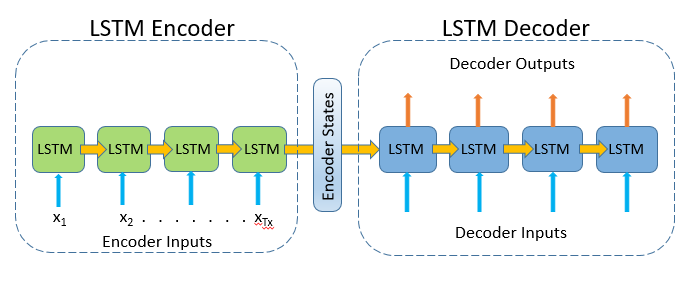
[image credit: https://miro.medium.com/max/864/1*5nvwJsH4EfONv_fdKNvobA.png]

#### Encoder:
**A stack of several recurrent units (LSTM or GRU cells for better performance) where each accepts a single element of the input sequence, collects information for that element and propagates it forward.**

#### Decoder:
**The decoder is also an LSTM network which reads the entire target sequence word-by-word and predicts the same sequence offset by one timestep. The decoder is trained to predict the next word in the sequence given the previous word.**

In [30]:
# importimg attention function from https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py
from attention import AttentionLayer

#### Here, we are building a 3 stacked LSTM for the encoder

In [31]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Model Summary

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 100)      1067000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## Compile the model:
We are using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector
This overcomes any memory issues.

In [33]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

### Early Stopping:
- `Early stopping` is useed to stop trainning when there is no improvement after substantial number of epoch
- we are keeping `patience` level 5 which mean we will be monitoring ateast 5 epoch to see if there is improvement in model
- In `min mode` the training will stop when the quantity monitored(validation loss) has stopped decreasing

In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=15)

### Learn Rate Decay:

In [35]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.01
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(step_decay)
# lrate = LearningRateScheduler(exp_decay)

## Training Model:
- we are training our model for 100 epochs with 128 batch size 

#### Check Available GPU

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(tf.__version__)

def check_GPU():
    local_devices = device_lib.list_local_devices()
    print("local_devices: ", local_devices)
    print("\n------------ Available GPUs: ------------\n", tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), " - Physical GPUs,", len(logical_gpus), " - Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)


check_GPU()

1.15.0
local_devices:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 956900051269148884
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18032941981553788356
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11897235047
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4967635920100335010
physical_device_desc: "device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:03:00.0, compute capability: 6.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16870871929938998789
physical_device_desc: "device: XLA_GPU device"
]

------------ Available GPUs: ------------
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
1  - Physical GPUs, 1  - Logical GPUs


In [37]:
history = model.fit([x_tr,y_tr[:,:-1]],
                    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], 
                    epochs=100,
                    callbacks=[es],
                    batch_size=128,
                    validation_data=([x_val,y_val[:,:-1]],
                                     y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 48889 samples, validate on 12200 samples
Epoch 1/100
48889/48889 [==============================] - 100s 2ms/sample - loss: 2.9471 - val_loss: 2.6900
Epoch 2/100
48889/48889 [==============================] - 96s 2ms/sample - loss: 2.6398 - val_loss: 2.5033
Epoch 3/100
48889/48889 [==============================] - 95s 2ms/sample - loss: 2.4775 - val_loss: 2.3840
Epoch 4/100
48889/48889 [==============================] - 93s 2ms/sample - loss: 2.3785 - val_loss: 2.3241
Epoch 5/100
48889/48889 [==============================] - 94s 2ms/sample - loss: 2.3098 - val_loss: 2.2799
Epoch 6/100
48889/48889 [==============================] - 94s 2ms/sample - loss: 2.2558 - val_loss: 2.2445
Epoch 7/100
48889/48889 [==============================] - 92s 2ms/sample - loss: 2.2115 - val_loss: 2.2153
Epoch 8/100
48889/48889 [==============================] - 92s 2ms/sample - loss: 2.1728 - val_loss

In [38]:
model.save('lstm_model.h5', include_optimizer=True)

### Understanding the Diagnostic plot:
Plotting trainig vs testing validation loss

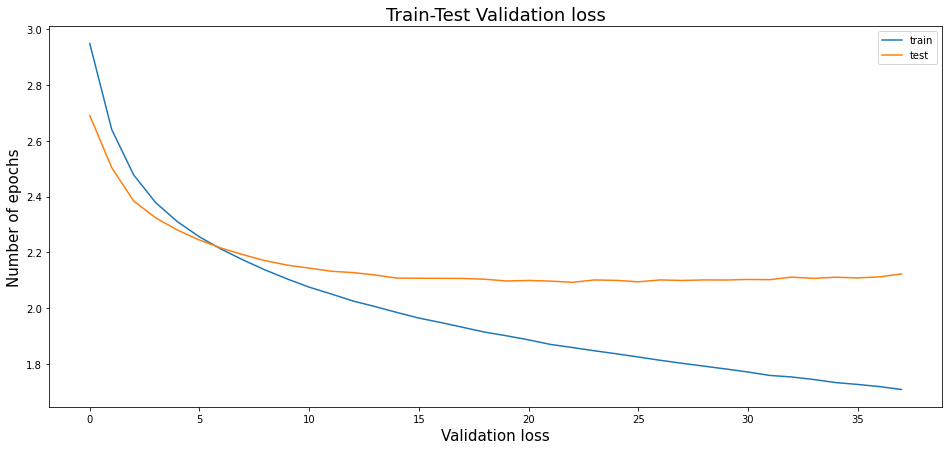

In [47]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Train-Test Validation loss', fontsize=18)
plt.xlabel('Validation loss', fontsize=15)
plt.ylabel('Number of epochs', fontsize=15)
plt.legend()
plt.show()

- We can infer from plot that after 30 epoches model no longer improving (decreasing loss) so we are stopping the trainning early

#### Build the dictionary to convert the index to word for summary prediction

In [48]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## 2. Inference Phase:
After training, the model is tested on new source sequences for which the target sequence is unknown. <br />
So, we need to set up the inference architecture to decode a test sequence:

### Creating Decoder model: Seq2Seq Model

In [49]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [50]:
decoder_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    228700      input_2[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 300)]        0                                            
____________________________________________________________________________________________

### Creating Decoding Sequence:
#### Steps:
    1. Encode the entire input sequence and initialize the decoder with internal states of the encoder
    2. Pass `start` token as an input to the decoder
    3. Run the decoder for one timestep with the internal states
    4. The output will be the probability for the next word. The word with the maximum probability will be selected
    5. Pass the sampled word as an input to the decoder in the next timestep and update the internal states with the current time step
    6. Repeat steps 3 – 5 until we generate `end` token or hit the maximum length of the target sequence

In [51]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Making predictions     
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

#### Creating _seq2summary_ and _seq2text_ functions to display Original and Predicted results

In [52]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

## Prediction 

In [53]:
for i in range(0, 100):
    print(f"{i+1}: Review: {seq2text(x_tr[i])}")
    print(f"   Original summary: {seq2summary(y_tr[i])}")
    print(f"   Predicted summary: {decode_sequence(x_tr[i].reshape(1,max_text_len))}")
    print("\n-----------------------------------------------------------------------")

1: Review: beans really good added ham slice cooking came great time made soup consistently yummy 
   Original summary: very tasty 
   Predicted summary:  great

-----------------------------------------------------------------------
2: Review: cashews hoping large fresh met expectations recommend koeze anyone looking purchase especially gift disappointed 
   Original summary: great 
   Predicted summary:  good but not great

-----------------------------------------------------------------------
3: Review: chill switch kiwi berry pour pretty wine glass relax enjoy repeat switch kiwi berry pleasing color tantalizing fruity taste enough carbonation pleasurable experience 
   Original summary: my throat 
   Predicted summary:  great for the price

-----------------------------------------------------------------------
4: Review: tea interesting scent like bergamot jasmine unusual flower brewed tea right sniffing dry tea unpleasant think stick republic tea yorkshire gold 
   Original summ